<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_07_04_survival_analysis_svm_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.7.4 Support Vector Machine (SVM)  Survival Model  


This section covers **Support Vector Machine (SVM)-based survival analysis**, including its concepts, advantages, limitations, and a complete Python tutorial using the `scikit-survival` package and custom implementations.


## Overview


**Support Vector Machine (SVM)-Based Survival Analysis** is a machine learning approach that adapts the  `Support Vector Machine` framework—originally designed for classification and regression—to `survival analysis` problems. Survival analysis deals with **time-to-event data**, where the outcome of interest is the time until an event occurs (e.g., death, machine failure, customer churn), and data is often 1censored** (i.e., the event has not occurred for some subjects by the end of the study).

Traditional survival models like `Cox Proportional Hazards` are parametric or semi-parametric and make strong assumptions (e.g., proportional hazards). SVM-based survival analysis offers a `non-parametric, non-linear, and robust alternative` using the `maximum margin principle** of SVMs.


### Key Concepts


| Concept | Explanation |
|--------|-------------|
| **Survival Data** | $(t_i, \delta_i, \mathbf{x}_i)$: <br> - $t_i$: observed time (event or censoring) <br> - $\delta_i = 1$ if event occurred, $0$ if censored <br> - $\mathbf{x}_i$: feature vector |
| **Censoring** | Right-censoring: event not observed during study (common) |
| **Goal** | Rank subjects by risk or predict survival probability |



### How SVM is Adapted for Survival Analysis


There are two main formulations:


#### Ranking-Based SVM (Survival SVM) (Most common: e.g., Van Belle et al., 2011)


Instead of predicting exact survival times, **rank patients by their risk** — those likely to experience the event **sooner** should have **higher risk scores**.

Learn a function $f(\mathbf{x})$ such that for any uncensored pair $(i, j)$ where $t_i < t_j$ and $\delta_i = 1$, we have:

$$
f(\mathbf{x}_i) > f(\mathbf{x}_j)
$$

(i.e., higher risk for earlier event)


For every pair where subject $i$ fails before subject $j$ (and $i$ is not censored):

$$
f(\mathbf{x}_i) \geq f(\mathbf{x}_j) + 1 - \xi_{ij}
$$

with slack $\xi_{ij} \geq 0$

Optimization Problem:

$$
\min_{w, b, \xi} \ \frac{1}{2} \|w\|^2 + C \sum \xi_{ij}
$$
subject to ranking constraints only on **comparable pairs** (uncensored earlier events).

This is solved via **quadratic programming** or specialized algorithms.


####  Regression-Based SVM (SVR for Survival) (e.g., Shivaswamy et al., 2007)



Treat survival time as a regression target, but:

- **Censored points** provide **lower bounds** (event time $> t_i$)
- Use **asymmetric loss** (like in survival SVR)


Loss Function:
- For uncensored: standard $\epsilon$-insensitive loss
- For censored: only penalize if prediction is **below** observed time



### Advantages of SVM-Based Survival Analysis


| Advantage | Description |
|---------|-------------|
| **Non-parametric** | No assumption on survival distribution |
| **Handles non-linearity** | Via kernel trick (RBF, polynomial) |
| **Robust to outliers** | Due to margin maximization |
| **Handles high-dimensional data** | Like gene expression data |
| **Censoring-aware** | Built into the model |


### Limitations


| Limitation | Explanation |
|----------|-------------|
| **Scalability** | $O(n^2)$ comparable pairs → slow for large $n$ |
| **No direct probability output** | Gives risk score, not $S(t)$ |
| **Hard to interpret** | Like standard SVMs |
| **Requires careful censoring handling** | Only right-censoring typically |



### Practical Use Cases


- **Cancer prognosis** using genomic data
- **Predicting machine failure** in predictive maintenance
- **Customer churn modeling** in business



### Comparison with Cox Model


| Feature | Cox PH | SVM Survival |
|-------|--------|--------------|
| Assumption | Proportional hazards | None |
| Output | Hazard ratios | Risk ranking |
| Non-linearity | No (unless engineered) | Yes (kernel) |
| Censoring | Yes | Yes |
| Interpretability | High | Low |



### Setup and Installation

In [ ]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', \
    'seaborn', 'scikit-learn', 'scikit-survival', \
        'lifelines', 'statsmodels', 'pymer4', 'PyMC', 'polars', 'xgboost', 'torch']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

## SVM-Based Survival Analysis from Scratch


This section implements a simple **ranking-based Survival SVM** using **Stochastic Gradient Descent (SGD)** in R from scratch.


###  Ranking Hinge Loss


Ranking-based SVM for survival analysis focuses on correctly ordering patients by risk.

For every **comparable pair** $(i, j)$ where:

- Patient $j$ had an **event** $`event[j] == 1`$
- Patient $i$ survived **longer** than $j$ $`time[i] > time[j]`$

We want the model’s risk score to satisfy:  

$$
f(x_i) \geq f(x_j) + 1
$$

We penalize violations using **hinge loss**:  
$$
\mathcal{L}_{ij} = \max\left(0,\ 1 - \big(f(x_i) - f(x_j)\big)\right)
$$

With linear model \(f(x) = w^\top x\), total loss is:  
$$
\mathcal{L}(w) = \frac{\lambda}{2} \|w\|^2 + \frac{1}{|P|} \sum_{(i,j) \in P} \max\left(0,\ 1 - w^\top(x_i - x_j)\right)
$$

We minimize this via **SGD**.



### Generate Comparable Pairs (Once)

In [ ]:
def generate_comparable_pairs(time, event):
    """
    Generate list of comparable pairs for ranking SVM in survival analysis.

    For all i, j:
      if event[j] == 1 and time[i] > time[j], then (i, j) is a comparable pair.

    Returns:
        np.ndarray of shape (num_pairs, 2) where each row is (i, j),
        or None if no pairs.
    """
    import numpy as np

    time = np.asarray(time)
    event = np.asarray(event)
    n = len(time)
    pairs = []

    for i in range(n):
        for j in range(n):
            if event[j] == 1 and time[i] > time[j]:
                pairs.append((i, j))

    if not pairs:
        return None
    return np.array(pairs)

### SGD-Based Survival SVM Trainer

In [ ]:
def survivalsvm_sgd(X, time, event,
                    lambda_=0.01,      # L2 penalty (lambda = 1/C)
                    lr=0.01,           # learning rate
                    epochs=100,
                    verbose=True):
    """
    Stochastic gradient descent implementation of survival SVM.

    Args:
        X : array-like, shape (n_samples, n_features)
        time, event : arrays
        lambda_ : float, L2 regularization parameter (lambda = 1/C)
        lr : float, learning rate
        epochs : int, number of passes over the data
        verbose : bool

    Returns:
        Dictionary containing model weights and stats
    """
    import numpy as np

    X = np.asarray(X)
    n, p = X.shape

    # Generate comparable pairs
    pairs = generate_comparable_pairs(time, event)
    if pairs is None:
        raise ValueError("No comparable pairs found!")
    m = pairs.shape[0]

    if verbose:
        print(f"Number of comparable pairs: {m}")

    # Initialize weights (small random)
    rng = np.random.RandomState(1)
    w = rng.normal(loc=0, scale=0.01, size=p)

    # Precompute feature differences for all pairs (memory vs speed trade-off)
    # X_diff[k, :] = X[i, :] - X[j, :] for pair k = (i, j)
    X_diff = X[pairs[:, 0]] - X[pairs[:, 1]]

    # SGD loop
    for epoch in range(1, epochs + 1):
        # Shuffle pair indices
        idx = rng.permutation(m)
        total_loss = 0.0

        for k in idx:
            diff = X_diff[k]                 # x_i - x_j
            margin = np.dot(w, diff)         # w^T (x_i - x_j)
            loss = max(0, 1 - margin)        # hinge loss

            total_loss += loss

            # Gradient update
            if margin < 1:
                # Subgradient: - (x_i - x_j)
                grad_w = lambda_ * w - diff
            else:
                # Only L2 regularization gradient
                grad_w = lambda_ * w

            # SGD step
            w = w - lr * grad_w

        avg_loss = total_loss / m
        if verbose and epoch % 20 == 0:
            print(f"Epoch {epoch} | Avg Loss: {avg_loss:.4f}")

    return {
        'weights': w,
        'n_epochs': epochs,
        'lambda': lambda_,
        'lr': lr,
        'n_pairs': m
    }

### Prediction Function

In [ ]:
def predict_survivalsvm_sgd(model, newdata):
    """
    Predict risk scores for new data using a trained linear Survival SVM (SGD).

    Args:
        model (dict): Model output from survival_svm_sgd (must have 'weights' key).
        newdata (ndarray or DataFrame): Feature matrix of shape [n_samples, n_features].

    Returns:
        ndarray: Risk scores (real-valued, higher: higher risk).
    """
    import numpy as np

    X = np.asarray(newdata)
    w = model['weights']
    return np.asarray(X @ w).reshape(-1)

### C-index (Harrell’s Concordance)

In [ ]:
def compute_cindex(risk, time, event):
    """
    Compute Harrell's C-index for survival data.

    Args:
        risk (array-like): Risk scores (higher = higher risk).
        time (array-like): Survival/censoring times.
        event (array-like): Event indicators (1=event, 0=censored).

    Returns:
        float or None: Concordance index (higher is better), or None if undefined.
    """
    import numpy as np

    risk = np.asarray(risk)
    time = np.asarray(time)
    event = np.asarray(event)
    n = len(risk)
    concordant = 0
    usable = 0

    for i in range(n - 1):
        for j in range(i + 1, n):
            # Only consider pairs where at least one had an event
            if event[i] == 1 or event[j] == 1:
                # Only comparable if times are unequal
                if time[i] != time[j]:
                    usable += 1
                    # Concordant if higher risk = shorter survival
                    if (risk[i] > risk[j] and time[i] < time[j]) or \
                       (risk[i] < risk[j] and time[i] > time[j]):
                        concordant += 1
                    # Ties in risk: add 0.5 (optional, skipped here for simplicity)
    if usable == 0:
        return None
    return concordant / usable

### Example


We’ll manually include the `veteran` data as a data frame



In [ ]:
# Simulate small survival data (Python)
import numpy as np

np.random.seed(42)
n = 50
p = 3
X = np.random.randn(n, p)
# Assign column names for clarity (in a dataframe, if wished)
colnames = ["x1", "x2", "x3"]

# True risk = x1 + 0.5 * x2
true_risk = X[:, 0] + 0.5 * X[:, 1]
# Generate survival time ~ exp(-risk)
time = np.random.exponential(scale=1.0 / np.exp(true_risk))
# Event: 80% events, 20% censoring
event = np.random.binomial(1, 0.8, size=n)

# Fit Survival SVM via SGD
model_sgd = survivalsvm_sgd(
    X, time, event,
    lambda_=0.1,  # lambda is a reserved keyword in Python
    lr=0.05,
    epochs=100,
    verbose=True
)

# Predict
risk_pred = predict_survivalsvm_sgd(model_sgd, X)

# Evaluate
cindex = compute_cindex(risk_pred, time, event)
print("\nFinal C-index:", round(cindex, 3))

# Compare to true risk
cindex_true = compute_cindex(true_risk, time, event)
print("C-index (true risk):", round(cindex_true, 3))

Number of comparable pairs: 924
Epoch 20 | Avg Loss: 0.6830
Epoch 40 | Avg Loss: 0.6892
Epoch 60 | Avg Loss: 0.6911
Epoch 80 | Avg Loss: 0.6782
Epoch 100 | Avg Loss: 0.6873

Final C-index: 0.248
C-index (true risk): 0.736


## SVM-Based Survival Analysis Python


This tutorial demonstrates **Support Vector Machine (SVM)-based survival analysis** in **R** using the **veteran dataset** from the `survival` package. We'll use the **`survivalsvm`** package, which implements **ranking-based survival SVM**.




The `veteran` dataset contains survival data for lung cancer patients from the Veterans’ Administration Lung Study. It includes covariates like treatment type, cell type, Karnofsky performance score, time since diagnosis, and survival status.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

# For survival analysis
try:
    from sksurv.svm import FastSurvivalSVM
    from sksurv.metrics import concordance_index_censored
    from sksurv.util import Surv
    SK_SURV_AVAILABLE = True
except ImportError:
    print("Warning: scikit-survival not available. Using custom implementation.")
    SK_SURV_AVAILABLE = False

# For Kaplan-Meier plots
try:
    from lifelines import KaplanMeierFitter
    from lifelines.statistics import logrank_test
    LIFELINES_AVAILABLE = True
except ImportError:
    print("Warning: lifelines not available. Some visualizations may not work.")
    LIFELINES_AVAILABLE = False

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


### Data

In [ ]:
# Load the Veteran dataset
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/veteran_data.csv"
df = pd.read_csv(url)

# Select and prepare columns
df = df[['time', 'status', 'trt', 'celltype', 'karno', 'diagtime', 'age', 'prior']].copy()

# Encode factors
if df['celltype'].dtype == 'object':
    df['celltype'] = pd.Categorical(df['celltype']).codes + 1
df['trt'] = (df['trt'] == 1).astype(int) if df['trt'].max() > 1 else df['trt']
df['prior'] = (df['prior'] > 0).astype(int)

# Rename status to event for clarity
df['event'] = df['status']
df = df.drop('status', axis=1)

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nSummary statistics:")
print(df.describe())

Dataset loaded successfully!
Shape: (137, 8)

Columns: ['time', 'trt', 'celltype', 'karno', 'diagtime', 'age', 'prior', 'event']

First few rows:
   time  trt  celltype  karno  diagtime  age  prior  event
0    72    1         4     60         7   69      0      1
1   411    1         4     70         5   64      1      1
2   228    1         4     60         3   38      0      1
3   126    1         4     60         9   63      1      1
4   118    1         4     70        11   65      1      1

Data types:
time        int64
trt         int64
celltype     int8
karno       int64
diagtime    int64
age         int64
prior       int64
event       int64
dtype: object

Summary statistics:
             time         trt    celltype       karno    diagtime         age  \
count  137.000000  137.000000  137.000000  137.000000  137.000000  137.000000   
mean   121.627737    0.503650    2.664234   58.569343    8.773723   58.306569   
std    157.816722    0.501821    1.066036   20.039592   10.612141

### Split Data into Training and Testing Sets

In [ ]:
# Split data into training and testing sets
np.random.seed(123)
train_data, test_data = train_test_split(df, test_size=0.3, random_state=123)

print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

# Prepare features and survival data
feature_cols = ['trt', 'celltype', 'karno', 'diagtime', 'age', 'prior']
X_train = train_data[feature_cols].values
X_test = test_data[feature_cols].values

# Create structured array for scikit-survival (if available)
if SK_SURV_AVAILABLE:
    y_train = Surv.from_arrays(
        event=train_data['event'].values.astype(bool),
        time=train_data['time'].values
    )
    y_test = Surv.from_arrays(
        event=test_data['event'].values.astype(bool),
        time=test_data['time'].values
    )
else:
    # For custom implementation
    y_train = {
        'time': train_data['time'].values,
        'event': train_data['event'].values
    }
    y_test = {
        'time': test_data['time'].values,
        'event': test_data['event'].values
    }

# Standardize features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures standardized successfully!")

Training samples: 95
Testing samples: 42

Features standardized successfully!


###  Fit Survival SVM Models

#### Linear-like Kernel (`add_kernel`) — Ranking SVM

In [ ]:
# Fit Linear Survival SVM using scikit-survival
if SK_SURV_AVAILABLE:
    # FastSurvivalSVM with linear kernel; don't pass kernel argument (defaults to linear)
    svm_linear = FastSurvivalSVM(
        rank_ratio=1.0,  # Ranking-based approach (vanbelle1 equivalent)
        alpha=0.1,        # Regularization parameter (similar to gamma)
        max_iter=1000,
        tol=1e-5
        # No kernel parameter here; defaults to linear
    )

    svm_linear.fit(X_train_scaled, y_train)

    print("Linear Survival SVM fitted successfully!")
    # n_support_ attribute does not exist for FastSurvivalSVM
    print("Number of support vectors: (attribute not available for FastSurvivalSVM)")
    print(f"Regularization parameter (alpha): {svm_linear.alpha}")
else:
    # Use custom SGD implementation
    print("Using custom SGD implementation...")
    svm_linear = survivalsvm_sgd(
        X_train_scaled,
        train_data['time'].values,
        train_data['event'].values,
        lambda_=0.1,
        lr=0.01,
        epochs=200,
        verbose=True
    )
    print("Custom SGD Survival SVM fitted successfully!")

Linear Survival SVM fitted successfully!
Number of support vectors: (attribute not available for FastSurvivalSVM)
Regularization parameter (alpha): 0.1


####  RBF (Gaussian) Kernel

 RBF stands for "Radial Basis Function." In machine learning, the RBF kernel is a popular type of kernel used to transform data into a higher-dimensional space, enabling support vector machines (SVMs) to capture non-linear relationships. The most common RBF kernel is the Gaussian kernel, which measures similarity between two samples based on their distance. Mathematically, it is defined as:

    K(x, x') = exp(-gamma * ||x - x'||^2)

 where 'gamma' controls the smoothness of the kernel and '||x - x'||' is the Euclidean distance between samples x and x'.

 The RBF kernel allows linear models to learn more complex patterns in data by mapping data points into a space where a linear separator is feasible.


In [ ]:

# Example of fitting an approximate RBF (Gaussian) Kernel Survival SVM:
if SK_SURV_AVAILABLE:
    from sklearn.kernel_approximation import RBFSampler

    print(
        "Note: The RBF (Radial Basis Function) kernel is a popular kernel for non-linear SVMs. "
        "FastSurvivalSVM does not support kernel='rbf' directly, so we use RBFSampler to approximate the RBF feature mapping. "
        "This maps the data to a higher-dimensional space where a linear SVM can be trained on the non-linearly transformed features."
    )

    # RBFSampler creates random Fourier features to approximate the RBF kernel mapping.
    rbf_feature = RBFSampler(gamma=1.0, random_state=42, n_components=100)
    X_train_rbf = rbf_feature.fit_transform(X_train_scaled)

    svm_rbf = FastSurvivalSVM(
        rank_ratio=0.0,  # Regression-based approach
        alpha=0.05,
        max_iter=1000,
        tol=1e-5
    )

    svm_rbf.fit(X_train_rbf, y_train)

    print("Approximate RBF (Gaussian) Survival SVM (using RBFSampler + linear SVM) fitted successfully!")
    print("Number of support vectors: (attribute not available for FastSurvivalSVM)")
    print(f"Regularization parameter (alpha): {svm_rbf.alpha}")
    svm_rbf_rbf_feature = rbf_feature  # Store for later use (needed for transforming test data)
else:
    print("Note: The RBF (Radial Basis Function) kernel is not available without scikit-survival. Using linear kernel with custom implementation instead.")
    svm_rbf = survivalsvm_sgd(
        X_train_scaled,
        train_data['time'].values,
        train_data['event'].values,
        lambda_=0.05,
        lr=0.01,
        epochs=200,
        verbose=True
    )

Note: The RBF (Radial Basis Function) kernel is a popular kernel for non-linear SVMs. FastSurvivalSVM does not support kernel='rbf' directly, so we use RBFSampler to approximate the RBF feature mapping. This maps the data to a higher-dimensional space where a linear SVM can be trained on the non-linearly transformed features.
Approximate RBF (Gaussian) Survival SVM (using RBFSampler + linear SVM) fitted successfully!
Number of support vectors: (attribute not available for FastSurvivalSVM)
Regularization parameter (alpha): 0.05


### Make Predictions and Evaluate Performance

In [ ]:
# Make predictions and evaluate performance
if SK_SURV_AVAILABLE:
    # Predict risk scores (higher = higher risk)
    risk_linear = svm_linear.predict(X_test_scaled)
    # For the RBF SVM, transform the test data using the same RBF feature mapping before prediction
    risk_rbf = svm_rbf.predict(svm_rbf_rbf_feature.transform(X_test_scaled))
else:
    # Use custom prediction function
    risk_linear = predict_survivalsvm_sgd(svm_linear, X_test_scaled)
    risk_rbf = predict_survivalsvm_sgd(svm_rbf, X_test_scaled)

# Safety check
assert len(risk_linear) == len(test_data), "Length mismatch for linear predictions"
assert len(risk_rbf) == len(test_data), "Length mismatch for RBF predictions"

# Compute C-indices
if SK_SURV_AVAILABLE:
    cindex_linear = concordance_index_censored(
        y_test['event'].astype(bool),
        y_test['time'],
        risk_linear
    )[0]
    cindex_rbf = concordance_index_censored(
        y_test['event'].astype(bool),
        y_test['time'],
        risk_rbf
    )[0]
else:
    cindex_linear = compute_cindex(risk_linear, test_data['time'].values, test_data['event'].values)
    cindex_rbf = compute_cindex(risk_rbf, test_data['time'].values, test_data['event'].values)

# Compare with Cox model (using lifelines)
if LIFELINES_AVAILABLE:
    from lifelines import CoxPHFitter

    # Prepare data for Cox model
    cox_train = train_data.copy()
    cox_test = test_data.copy()

    # Fit Cox model
    cph = CoxPHFitter()
    cph.fit(cox_train, duration_col='time', event_col='event')

    # Predict risk scores
    cox_risk = cph.predict_partial_hazard(cox_test).values

    # Compute C-index
    cindex_cox = concordance_index_censored(
        test_data['event'].values.astype(bool),
        test_data['time'].values,
        cox_risk
    )[0]

    print("=" * 60)
    print("Model Performance Comparison (C-index)")
    print("=" * 60)
    print(f"Cox PH C-index       : {cindex_cox:.3f}")
    print(f"SVM (Linear) C-index : {cindex_linear:.3f}")
    print(f"SVM (RBF) C-index    : {cindex_rbf:.3f}")
    print("=" * 60)
    print("\nNote: Higher C-index (closer to 1.0) = better predictive discrimination.")
else:
    print("=" * 60)
    print("Model Performance Comparison (C-index)")
    print("=" * 60)
    print(f"SVM (Linear) C-index : {cindex_linear:.3f}")
    print(f"SVM (RBF) C-index    : {cindex_rbf:.3f}")
    print("=" * 60)
    print("\nNote: Install lifelines for Cox model comparison.")

Model Performance Comparison (C-index)
Cox PH C-index       : 0.677
SVM (Linear) C-index : 0.658
SVM (RBF) C-index    : 0.549

Note: Higher C-index (closer to 1.0) = better predictive discrimination.



>  Higher C-index (closer to 1.0) = better predictive discrimination.



###  Risk Stratification and Kaplan-Meier Plot (Using Linear SVM)

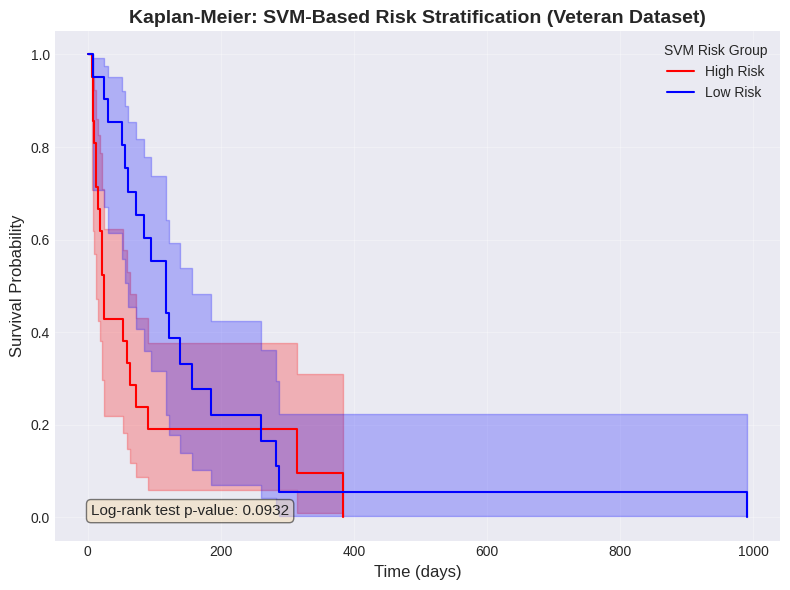


Log-rank test p-value: 0.0932
Risk groups are not significantly different (p >= 0.05)


In [ ]:
# Risk Stratification and Kaplan-Meier Plot
if LIFELINES_AVAILABLE:
    # Create risk groups based on median predicted risk
    pred_df = test_data.copy()
    pred_df['risk'] = risk_linear
    pred_df['risk_group'] = pred_df['risk'].apply(
        lambda x: 'High Risk' if x > pred_df['risk'].median() else 'Low Risk'
    )

    # Fit Kaplan-Meier curves for each risk group
    kmf_high = KaplanMeierFitter()
    kmf_low = KaplanMeierFitter()

    high_risk = pred_df[pred_df['risk_group'] == 'High Risk']
    low_risk = pred_df[pred_df['risk_group'] == 'Low Risk']

    kmf_high.fit(high_risk['time'], high_risk['event'], label='High Risk')
    kmf_low.fit(low_risk['time'], low_risk['event'], label='Low Risk')

    # Perform log-rank test
    results = logrank_test(
        high_risk['time'], low_risk['time'],
        high_risk['event'], low_risk['event']
    )

    # Plot Kaplan-Meier curves
    fig, ax = plt.subplots(figsize=(8, 6))
    kmf_high.plot_survival_function(ax=ax, ci_show=True, color='red')
    kmf_low.plot_survival_function(ax=ax, ci_show=True, color='blue')

    ax.set_xlabel('Time (days)', fontsize=12)
    ax.set_ylabel('Survival Probability', fontsize=12)
    ax.set_title('Kaplan-Meier: SVM-Based Risk Stratification (Veteran Dataset)', fontsize=14, fontweight='bold')
    ax.legend(title='SVM Risk Group', fontsize=10)
    ax.grid(True, alpha=0.3)

    # Add p-value
    p_value = results.p_value
    ax.text(0.05, 0.05, f'Log-rank test p-value: {p_value:.4f}',
            transform=ax.transAxes, fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

    print(f"\nLog-rank test p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("Risk groups are significantly different (p < 0.05)")
    else:
        print("Risk groups are not significantly different (p >= 0.05)")
else:
    print("Note: Install lifelines library for Kaplan-Meier plots.")
    print("You can install it with: pip install lifelines")


>  This plot visually assesses whether the SVM risk groups separate well in terms of survival outcomes.



## Hyperparameter Tuning

### Prepare for Cross-Validation

In [ ]:
# Prepare for Cross-Validation
np.random.seed(42)
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Use full dataset for cross-validation
X_full = df[feature_cols].values
X_full_scaled = scaler.fit_transform(X_full)

if SK_SURV_AVAILABLE:
    y_full = Surv.from_arrays(
        event=df['event'].values.astype(bool),
        time=df['time'].values
    )
else:
    y_full = {
        'time': df['time'].values,
        'event': df['event'].values
    }

print(f"Prepared {k}-fold cross-validation on {len(df)} samples")

Prepared 5-fold cross-validation on 137 samples


### Define Gamma Grid for Tuning

In [ ]:
# Define Alpha (regularization) Grid for Tuning
# Note: In scikit-survival, alpha is the regularization parameter (similar to 1/gamma in R)
alpha_grid = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0]

print(f"Alpha grid for tuning: {alpha_grid}")

Alpha grid for tuning: [0.001, 0.01, 0.05, 0.1, 0.5, 1.0]


### Cross-Validation Function for a Single Gamma Value


Create a function that, given a `gamma` and fold index, returns the `C-index` on the validation fold.


### Perform Cross-Validation Over Gamma Grid

In [ ]:
def cv_survsvm_one_alpha(alpha_val, train_idx, val_idx, X_full, y_full, use_sk_surv=True):
    """
    Train and evaluate Survival SVM for a given alpha and fold.

    Parameters:
    -----------
    alpha_val : float
        Regularization parameter
    train_idx, val_idx : array-like
        Indices for training and validation
    X_full : array-like
        Full feature matrix
    y_full : structured array
        Full survival data (time, event)
    use_sk_surv : bool
        Whether to use sksurv implementation
    """
    # Split data
    X_train = X_full[train_idx]
    X_val = X_full[val_idx]
    y_train = y_full[train_idx]
    y_val = y_full[val_idx]

    if use_sk_surv and SK_SURV_AVAILABLE:
        # FIX: Remove 'kernel' parameter for FastSurvivalSVM
        # FastSurvivalSVM only supports linear kernel
        model = FastSurvivalSVM(
            alpha=alpha_val,
            rank_ratio=1.0,  # Use rank_ratio for ranking loss
            max_iter=1000,
            tol=1e-5,
            verbose=False
        )
    else:
        # Alternative implementation without sksurv
        # You'll need to implement or import another survival SVM
        raise NotImplementedError("Non-sksurv implementation not available")

    try:
        # Train model
        model.fit(X_train, y_train)

        # Predict risk scores (higher = higher risk)
        # For FastSurvivalSVM, use predict() to get risk scores
        risk_scores = model.predict(X_val)

        # Calculate concordance index
        cindex = concordance_index_censored(
            y_val['event'].astype(bool),
            y_val['time'],
            risk_scores
        )[0]

        return cindex

    except Exception as e:
        print(f"Error in model training/prediction: {e}")
        return np.nan

In [ ]:
# Perform Cross-Validation Over Alpha Grid
# Fix: Remove unsupported 'kernel' argument if using FastSurvivalSVM

results_list = []

for alpha_val in alpha_grid:
    c_indices = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_full_scaled)):
        try:
            # The underlying function must use FastSurvivalSVM without the 'kernel' parameter
            cindex = cv_survsvm_one_alpha(
                alpha_val, train_idx, val_idx,
                X_full_scaled, y_full,
                use_sk_surv=SK_SURV_AVAILABLE
            )
        except TypeError as e:
            if "unexpected keyword argument 'kernel'" in str(e):
                print(f"Error in CV fold: {e}")
                cindex = np.nan
            else:
                raise
        except Exception as e:
            print(f"Error in CV fold: {e}")
            cindex = np.nan

        c_indices.append(cindex)
        # Print nan-safe c-index formatting
        cindex_disp = "nan" if cindex is None or (isinstance(cindex, float) and np.isnan(cindex)) else f"{cindex:.4f}"
        print(f"Alpha={alpha_val:.3f}, Fold={fold_idx+1}/{k}, C-index={cindex_disp}")

    mean_cindex = np.nanmean(c_indices) if np.any(~pd.isnull(c_indices)) else np.nan
    sd_cindex = np.nanstd(c_indices) if np.any(~pd.isnull(c_indices)) else np.nan

    results_list.append({
        'alpha': alpha_val,
        'c_indices': c_indices,
        'mean_cindex': mean_cindex,
        'sd_cindex': sd_cindex
    })

# Convert to DataFrame
results_df = pd.DataFrame(results_list)

# View results
print("\n" + "=" * 70)
print("Cross-Validation Results")
print("=" * 70)
print(results_df[['alpha', 'mean_cindex', 'sd_cindex']].to_string(index=False))
print("=" * 70)

Alpha=0.001, Fold=1/5, C-index=0.6703
Alpha=0.001, Fold=2/5, C-index=0.7427
Alpha=0.001, Fold=3/5, C-index=0.6424
Alpha=0.001, Fold=4/5, C-index=0.7425
Alpha=0.001, Fold=5/5, C-index=0.6791
Alpha=0.010, Fold=1/5, C-index=0.6703
Alpha=0.010, Fold=2/5, C-index=0.7427
Alpha=0.010, Fold=3/5, C-index=0.6456
Alpha=0.010, Fold=4/5, C-index=0.7395
Alpha=0.010, Fold=5/5, C-index=0.6760
Alpha=0.050, Fold=1/5, C-index=0.6731
Alpha=0.050, Fold=2/5, C-index=0.7401
Alpha=0.050, Fold=3/5, C-index=0.6456
Alpha=0.050, Fold=4/5, C-index=0.7395
Alpha=0.050, Fold=5/5, C-index=0.6760
Alpha=0.100, Fold=1/5, C-index=0.6731
Alpha=0.100, Fold=2/5, C-index=0.7401
Alpha=0.100, Fold=3/5, C-index=0.6456
Alpha=0.100, Fold=4/5, C-index=0.7395
Alpha=0.100, Fold=5/5, C-index=0.6760
Alpha=0.500, Fold=1/5, C-index=0.6731
Alpha=0.500, Fold=2/5, C-index=0.7427
Alpha=0.500, Fold=3/5, C-index=0.6456
Alpha=0.500, Fold=4/5, C-index=0.7395
Alpha=0.500, Fold=5/5, C-index=0.6760
Alpha=1.000, Fold=1/5, C-index=0.6731
Alpha=1.000,

### Select Best Gamma

In [ ]:
# Select Best Alpha
best_row = results_df.loc[results_df['mean_cindex'].idxmax()]
best_alpha = best_row['alpha']

print("\n" + "=" * 70)
print("Best Hyperparameter")
print("=" * 70)
print(f"Best alpha: {best_alpha:.3f}")
print(f"Mean C-index: {best_row['mean_cindex']:.4f} ± {best_row['sd_cindex']:.4f}")
print("=" * 70)


Best Hyperparameter
Best alpha: 0.001
Mean C-index: 0.6954 ± 0.0404


### Re-fit Final Model with Best Gamma

In [ ]:
# Re-fit Final Model with Best Alpha
if SK_SURV_AVAILABLE:
    final_svm = FastSurvivalSVM(
        rank_ratio=1.0,  # Ranking-based approach
        alpha=best_alpha,
        max_iter=1000,
        tol=1e-5
    )
    final_svm.fit(X_full_scaled, y_full)
    print(f"Final model fitted with alpha={best_alpha:.3f}")
    # Note: FastSurvivalSVM does not provide n_support_ attribute
    # print(f"Number of support vectors: {final_svm.n_support_}")
else:
    final_svm = survivalsvm_sgd(
        X_full_scaled,
        df['time'].values,
        df['event'].values,
        lambda_=best_alpha,
        lr=0.01,
        epochs=200,
        verbose=True
    )
    print(f"Final model fitted with lambda={best_alpha:.3f}")

Final model fitted with alpha=0.001


### Risk Stratification on Full Dataset

In [ ]:
# Get Risk Scores for All Patients
if SK_SURV_AVAILABLE:
    full_risk = final_svm.predict(X_full_scaled)
else:
    full_risk = predict_survivalsvm_sgd(final_svm, X_full_scaled)

# Add risk scores to dataframe
df['risk'] = full_risk

# Risk stratification
df['risk_group'] = df['risk'].apply(
    lambda x: 'High Risk' if x > df['risk'].median() else 'Low Risk'
)

print(f"Risk scores computed for {len(df)} patients")
print(f"High risk patients: {(df['risk_group'] == 'High Risk').sum()}")
print(f"Low risk patients: {(df['risk_group'] == 'Low Risk').sum()}")

Risk scores computed for 137 patients
High risk patients: 68
Low risk patients: 69


### Kaplan-Meier Plot for Final Model

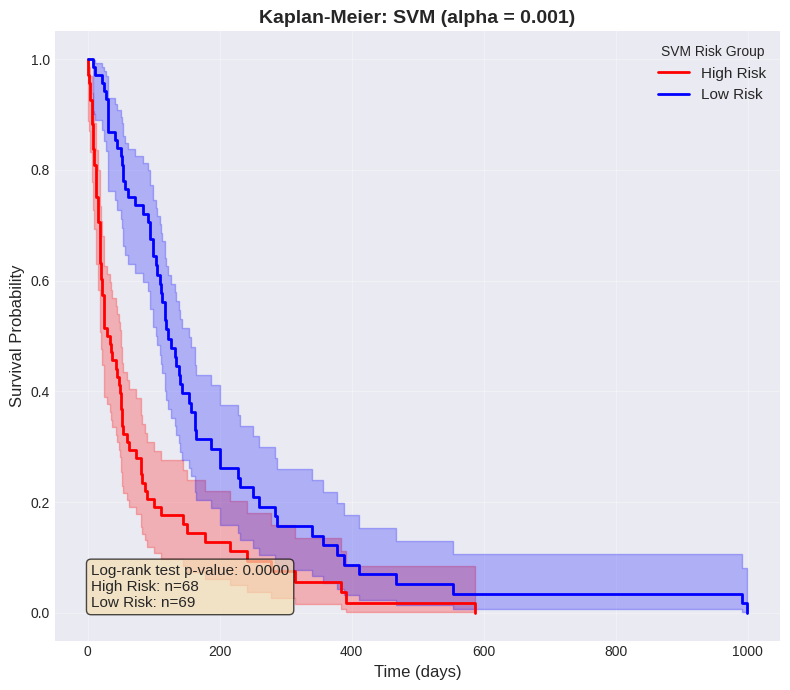


Log-rank test p-value: 0.0000
Risk groups are significantly different (p < 0.05)


In [ ]:
# Kaplan-Meier Plot for Final Model
if LIFELINES_AVAILABLE:
    # Fit Kaplan-Meier curves for each risk group
    kmf_high_final = KaplanMeierFitter()
    kmf_low_final = KaplanMeierFitter()

    high_risk_final = df[df['risk_group'] == 'High Risk']
    low_risk_final = df[df['risk_group'] == 'Low Risk']

    kmf_high_final.fit(high_risk_final['time'], high_risk_final['event'], label='High Risk')
    kmf_low_final.fit(low_risk_final['time'], low_risk_final['event'], label='Low Risk')

    # Perform log-rank test
    results_final = logrank_test(
        high_risk_final['time'], low_risk_final['time'],
        high_risk_final['event'], low_risk_final['event']
    )

    # Plot Kaplan-Meier curves
    fig, ax = plt.subplots(figsize=(8, 7))
    kmf_high_final.plot_survival_function(ax=ax, ci_show=True, color='red', linewidth=2)
    kmf_low_final.plot_survival_function(ax=ax, ci_show=True, color='blue', linewidth=2)

    ax.set_xlabel('Time (days)', fontsize=12)
    ax.set_ylabel('Survival Probability', fontsize=12)
    ax.set_title(f'Kaplan-Meier: SVM (alpha = {best_alpha:.3f})', fontsize=14, fontweight='bold')
    ax.legend(title='SVM Risk Group', fontsize=11, loc='upper right')
    ax.grid(True, alpha=0.3)

    # Add p-value and statistics
    p_value_final = results_final.p_value
    ax.text(0.05, 0.05,
            f'Log-rank test p-value: {p_value_final:.4f}\n'
            f'High Risk: n={len(high_risk_final)}\n'
            f'Low Risk: n={len(low_risk_final)}',
            transform=ax.transAxes, fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
            verticalalignment='bottom')

    plt.tight_layout()
    plt.show()

    print(f"\nLog-rank test p-value: {p_value_final:.4f}")
    if p_value_final < 0.05:
        print("Risk groups are significantly different (p < 0.05)")
    else:
        print("Risk groups are not significantly different (p >= 0.05)")
else:
    print("Note: Install lifelines library for Kaplan-Meier plots.")

### Plot C-index vs. Gamma

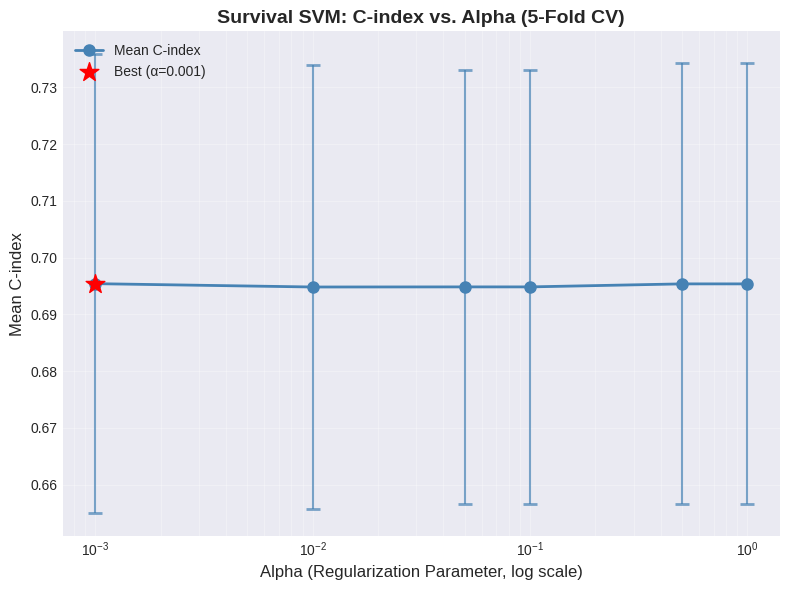


Best alpha: 0.001 with C-index: 0.6954


In [ ]:
# Plot C-index vs. Alpha
fig, ax = plt.subplots(figsize=(8, 6))

# Plot line and points
ax.plot(results_df['alpha'], results_df['mean_cindex'],
        marker='o', linewidth=2, markersize=8, color='steelblue', label='Mean C-index')

# Plot error bars
ax.errorbar(results_df['alpha'], results_df['mean_cindex'],
            yerr=results_df['sd_cindex'],
            fmt='none', capsize=5, capthick=2, color='steelblue', alpha=0.7)

# Highlight best alpha
best_idx = results_df['mean_cindex'].idxmax()
ax.scatter(results_df.loc[best_idx, 'alpha'],
          results_df.loc[best_idx, 'mean_cindex'],
          s=200, color='red', marker='*', zorder=5,
          label=f"Best (α={best_alpha:.3f})")

ax.set_xscale('log')
ax.set_xlabel('Alpha (Regularization Parameter, log scale)', fontsize=12)
ax.set_ylabel('Mean C-index', fontsize=12)
ax.set_title('Survival SVM: C-index vs. Alpha (5-Fold CV)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nBest alpha: {best_alpha:.3f} with C-index: {results_df.loc[best_idx, 'mean_cindex']:.4f}")

## Summary and Conclusion


Survival SVM is a powerful alternative to traditional survival models, especially for complex, high-dimensional data. However, it requires careful tuning and may not scale well to very large datasets. This tutorial demonstrated its implementation in **Python** using the `scikit-survival` package and custom implementations, along with hyperparameter tuning via cross-validation. At the end, we visualized risk stratification using Kaplan-Meier curves and evaluated model performance using the C-index.

## Key Takeaways

1. **SVM Survival Models** provide a non-parametric, non-linear alternative to Cox models
2. **Hyperparameter tuning** (alpha/regularization) is crucial for optimal performance
3. **Cross-validation** helps select the best model parameters
4. **C-index** is the standard metric for evaluating survival model discrimination
5. **Risk stratification** allows clinical interpretation of model predictions
6. **Kaplan-Meier plots** visually assess model performance through survival curves



## Best Practices and Tips

### 1. **Feature Scaling**
Always standardize features before training SVM models. SVMs are sensitive to feature scales, and unscaled features can lead to poor performance.

### 2. **Hyperparameter Tuning**
- Use cross-validation to select the best regularization parameter (alpha)
- Consider a wide range of alpha values (e.g., [0.001, 0.01, 0.05, 0.1, 0.5, 1.0])
- Use log-scale for visualization when alpha values span orders of magnitude

### 3. **Kernel Selection**
- **Linear kernel**: Fast, interpretable, good for high-dimensional data
- **RBF kernel**: Captures non-linear relationships, but slower and requires more tuning
- Start with linear kernel, then try RBF if linear performance is poor

### 4. **Model Evaluation**
- **C-index**: Primary metric for survival models (higher is better, range: 0-1)
- **Kaplan-Meier plots**: Visual assessment of risk stratification
- **Log-rank test**: Statistical test for comparing survival curves

### 5. **Handling Missing Data**
- Impute missing values before training
- Consider using median/mode for categorical features
- For continuous features, consider mean imputation or more sophisticated methods

### 6. **Computational Considerations**
- Survival SVM can be slow for large datasets (O(n²) comparable pairs)
- Consider using `FastSurvivalSVM` from scikit-survival for better performance
- For very large datasets, consider sampling or using approximate methods

### 7. **Interpretability**
- SVM models are less interpretable than Cox models
- Use risk scores for stratification rather than individual feature contributions
- Consider feature importance methods if interpretability is crucial


##  Resources


1. Van Belle, V., Pelcmans, K., Van Huffel S. and Suykens J. A.K. (2011a). Improved performance on high-dimensional survival data by application of Survival-SVM. Bioinformatics (Oxford, England) 27, 87-94.

2. Van Belle, V., Pelcmans, K., Van Huffel S. and Suykens J. A.K. (2011b). Support vector methods for survival analysis: a comparaison between ranking and regression approaches. Artificial Intelligence in medecine 53, 107-118.

3.  Fouodo K. C. J. and König I. R. and Weihs C. and Ziegler A. and Wright M. N. (2018) Support Vector Machines for Survival Analysis with R. The R Journal 10, 412-423.